In [120]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer


from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [121]:
data = pd.read_csv("data/1600000.processed.noemoticon.csv", encoding='latin-1')
# o.decode('latin-1').encode("utf-8")

In [122]:
print(data.head())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [123]:
new_data = data.iloc[:, [0,5]]

print(new_data.head())

   0  \
0  0   
1  0   
2  0   
3  0   
4  0   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....                                                                   
4                      @Kwesidei not the whole crew                                                                    


In [124]:
def clean_tweet(tweet):
    
    excluded_punct = [".", ",", ":", "^", ";", "#", "-", "_"]
    
    tweet_list = tweet.split()
    clean_tokens = [re.sub('@[\w]+','',t) for t in tweet_list if re.match(r'[^\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_url = re.sub(r'http\S+', '', clean_s)

    clean_punctuation = re.sub('(?<! )(?=[-.,#!?()_])|(?<=[-.,#!?()_])(?! )', ' ', clean_url)
    clean_mess = [word.lower() for word in clean_punctuation.split() if word.lower() not in stopwords.words('english') and word not in  excluded_punct]

    return clean_mess

cell = 1

text = new_data.iloc[cell, 1]

print(text)
print("\n--------------\n")
print(clean_tweet(text))

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

--------------

['dived', 'many', 'times', 'ball', 'managed', 'save', 'rest', 'go', 'bounds']


In [125]:
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

print(normalization(new_data.iloc[1,1].split()))

['@Kenichan', 'I', 'dive', 'many', 'time', 'for', 'the', 'ball.', 'Managed', 'to', 'save', '50%', 'The', 'rest', 'go', 'out', 'of', 'bound']


In [126]:
def delete_long_words(vocabulary):
    new_vocab = []
    for i in range(len(vocabulary)):
        if len(vocabulary[i]) <= 15:
            new_vocab.append(vocabulary[i])
            
    return new_vocab

In [127]:
def text_processing(tweet):
    return delete_long_words(normalization(clean_tweet(tweet)))

print(text_processing(new_data.iloc[1, 1]))

['dive', 'many', 'time', 'ball', 'manage', 'save', 'rest', 'go', 'bound']


### Create Bag Of Words

In [128]:
processed_sentence = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary = [inner for outer in processed_sentence for inner in outer]

In [129]:
print(vocabulary[:10])

['upset', "can't", 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today']


In [130]:
freq_dist = FreqDist(vocabulary)
freq_dist.most_common(10)

[('!', 11017),
 ('?', 3036),
 ('get', 2229),
 ('go', 2039),
 ("i'm", 1636),
 ('work', 1415),
 ('good', 1232),
 ('day', 1189),
 ('today', 1009),
 ('like', 953)]

In [131]:
FreqDist(len(w) for w in vocabulary).most_common()

[(4, 42170),
 (5, 27384),
 (3, 22926),
 (1, 16735),
 (6, 16020),
 (7, 11105),
 (2, 6319),
 (8, 6205),
 (9, 3919),
 (10, 2160),
 (11, 968),
 (12, 527),
 (13, 310),
 (14, 129),
 (15, 118)]

### Model

In [132]:
X_train, X_test, y_train, y_test = train_test_split(new_data.iloc[:, 1], new_data.iloc[:, 0], test_size=0.25)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
#param = [MultinomialNB(), LogisticRegression(penalty='l2', tol=0.001, C=1)]

# MNB : ; LR : 0.73933

alpha = [1, 0.1, 0.01, 0.001, 0]
prior = [False, True]


for i in range(len(prior)):
    for j in range(len(alpha)):

        pipeline = Pipeline([
            ('bow',CountVectorizer(analyzer=text_processing)), 
            ('tfidf', TfidfTransformer()),  
            ('classifier', MultinomialNB(alpha=alpha[j], fit_prior=prior[i])),  
        ])
        print("ALPHA : ", alpha[j], ", PRIOR : ", prior[i])
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_valid)
        print(accuracy_score(predictions, y_valid))

In [ ]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_valid)
print(classification_report(predictions, y_valid))
print(confusion_matrix(predictions, y_valid))
print(accuracy_score(predictions, y_valid))

In [133]:

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)), 
    ('tfidf', TfidfTransformer()),  
    ('classifier', LogisticRegression(penalty='l2', tol=0.001, C=1)),  
])


In [134]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

# 0.74275 

/Users/jordisaleilles/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2432
           4       0.76      0.73      0.74      2568

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000

[[1827  605]
 [ 692 1876]]
0.7406


In [135]:
unique, counts = np.unique(predictions, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 2432]
 [   4 2568]]


### Bi-grams

In [136]:
tokens = [inner for outer in processed_sentence for inner in outer]
def get_bigrams(tokens):
    return [(tokens[i],tokens[i+1]) for i in range(0,len(tokens)-1)]
 
bigrams_vocab = get_bigrams(tokens)

In [137]:
freq_dist = FreqDist(bigrams_vocab)
common_bigrams = freq_dist.most_common(15)

In [138]:
for i in common_bigrams:
    print(i[0])

('!', '!')
('?', '?')
('good', 'morning')
('last', 'night')
('?', '!')
('!', "i'm")
('!', 'thank')
('day', '!')
('thank', '!')
('!', 'get')
('!', 'love')
('feel', 'like')
('!', 'good')
('today', '!')
('morning', '!')


### Subjectivity and Objectivity

In [139]:
# how subjective or opinionated the text is; a score of 0 is fact, and a score of +1 is very much an opinion
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# how positive or negative the text is;
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity


sentences_info = {'Subjectivity':[], 'Polarity':[], 'Sentiment': []} 

concat_pro_words = new_data.iloc[:, 1].apply(text_processing).str.join(" ").to_list()

for i in range(len(concat_pro_words)):
    sentiment = getPolarity(concat_pro_words[i])
    sentences_info['Subjectivity'].append(getSubjectivity(concat_pro_words[i]))
    sentences_info['Polarity'].append(sentiment)
    
    if sentiment == 0:
        sentences_info['Sentiment'].append('Neutral')
    elif sentiment > 0:
        sentences_info['Sentiment'].append('Positive')
    else:
        sentences_info['Sentiment'].append('Negative')

    
sentences_info = pd.DataFrame(sentences_info) 


In [140]:
print(sentences_info.iloc[:5, ])

   Subjectivity  Polarity Sentiment
0           0.0     0.000   Neutral
1           0.5     0.500  Positive
2           0.4     0.200  Positive
3           1.0    -0.625  Negative
4           0.4     0.200  Positive


In [141]:
print(new_data.iloc[:, 0].value_counts())
print("\n-----------\n")
print(sentences_info.iloc[:, 2].value_counts())


4    10001
0     9998
Name: 0, dtype: int64

-----------

Positive    8319
Neutral     8033
Negative    3647
Name: Sentiment, dtype: int64


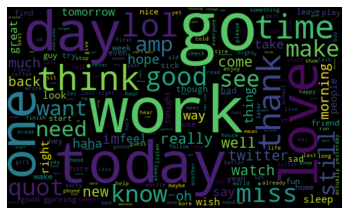

In [142]:
allWords = ' '.join([twts for twts in concat_pro_words])
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=100).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
def predict_tweets_sent(tweets, model):
    tweets_predictions = model.predict(tweets)

    unique, counts = np.unique(tweets_predictions, return_counts=True)

    pred_counts = np.asarray((unique, counts)).T

    if pred_counts[0][0] == 4:
        percentage = (pred_counts[0][1] * 100 / len(tweets_predictions)).round(2)
    else:
        percentage = (100 - (pred_counts[0][1] * 100 / len(tweets_predictions))).round(2)

    return percentage

percentage = predict_tweets_sent(new_data.iloc[:, 1], pipeline)